In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
!tar xzvf food-101.tar.gz

Streaming output truncated to the last 5000 lines.
food-101/images/cannoli/695879.jpg
food-101/images/cannoli/1767088.jpg
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.jpg
food-101/images/cannoli/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2

In [ ]:
%cd /content/food-101/

/content/food-101


In [ ]:
# Check the extracted dataset folder
!ls /content/food-101

images	license_agreement.txt  meta  README.txt


In [ ]:
os.listdir('/content/food-101/images')

['gnocchi',
 'ice_cream',
 'waffles',
 'creme_brulee',
 'beef_tartare',
 'ravioli',
 'falafel',
 'mussels',
 'oysters',
 'samosa',
 'deviled_eggs',
 'french_toast',
 'pho',
 'grilled_cheese_sandwich',
 'club_sandwich',
 'risotto',
 'takoyaki',
 'fish_and_chips',
 'tacos',
 'filet_mignon',
 'clam_chowder',
 'chicken_quesadilla',
 'escargots',
 'bread_pudding',
 'steak',
 'guacamole',
 'cup_cakes',
 'scallops',
 'beignets',
 'spring_rolls',
 'paella',
 'beet_salad',
 'omelette',
 'peking_duck',
 'hummus',
 'garlic_bread',
 'donuts',
 'french_onion_soup',
 'huevos_rancheros',
 'bruschetta',
 'shrimp_and_grits',
 'seaweed_salad',
 'croque_madame',
 'chicken_wings',
 'sashimi',
 'greek_salad',
 'onion_rings',
 'spaghetti_bolognese',
 'macaroni_and_cheese',
 'miso_soup',
 'french_fries',
 'gyoza',
 'prime_rib',
 'pancakes',
 'fried_rice',
 'lobster_roll_sandwich',
 'panna_cotta',
 'pulled_pork_sandwich',
 'spaghetti_carbonara',
 'caprese_salad',
 'sushi',
 'bibimbap',
 'cheesecake',
 'pad_th

In [ ]:
os.listdir('/content/food-101/meta')

['train.json',
 'train.txt',
 'classes.txt',
 'test.txt',
 'test.json',
 'labels.txt']

In [ ]:
!head /content/food-101/meta/train.txt

apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856


In [ ]:
!head /content/food-101/meta/classes.txt

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito


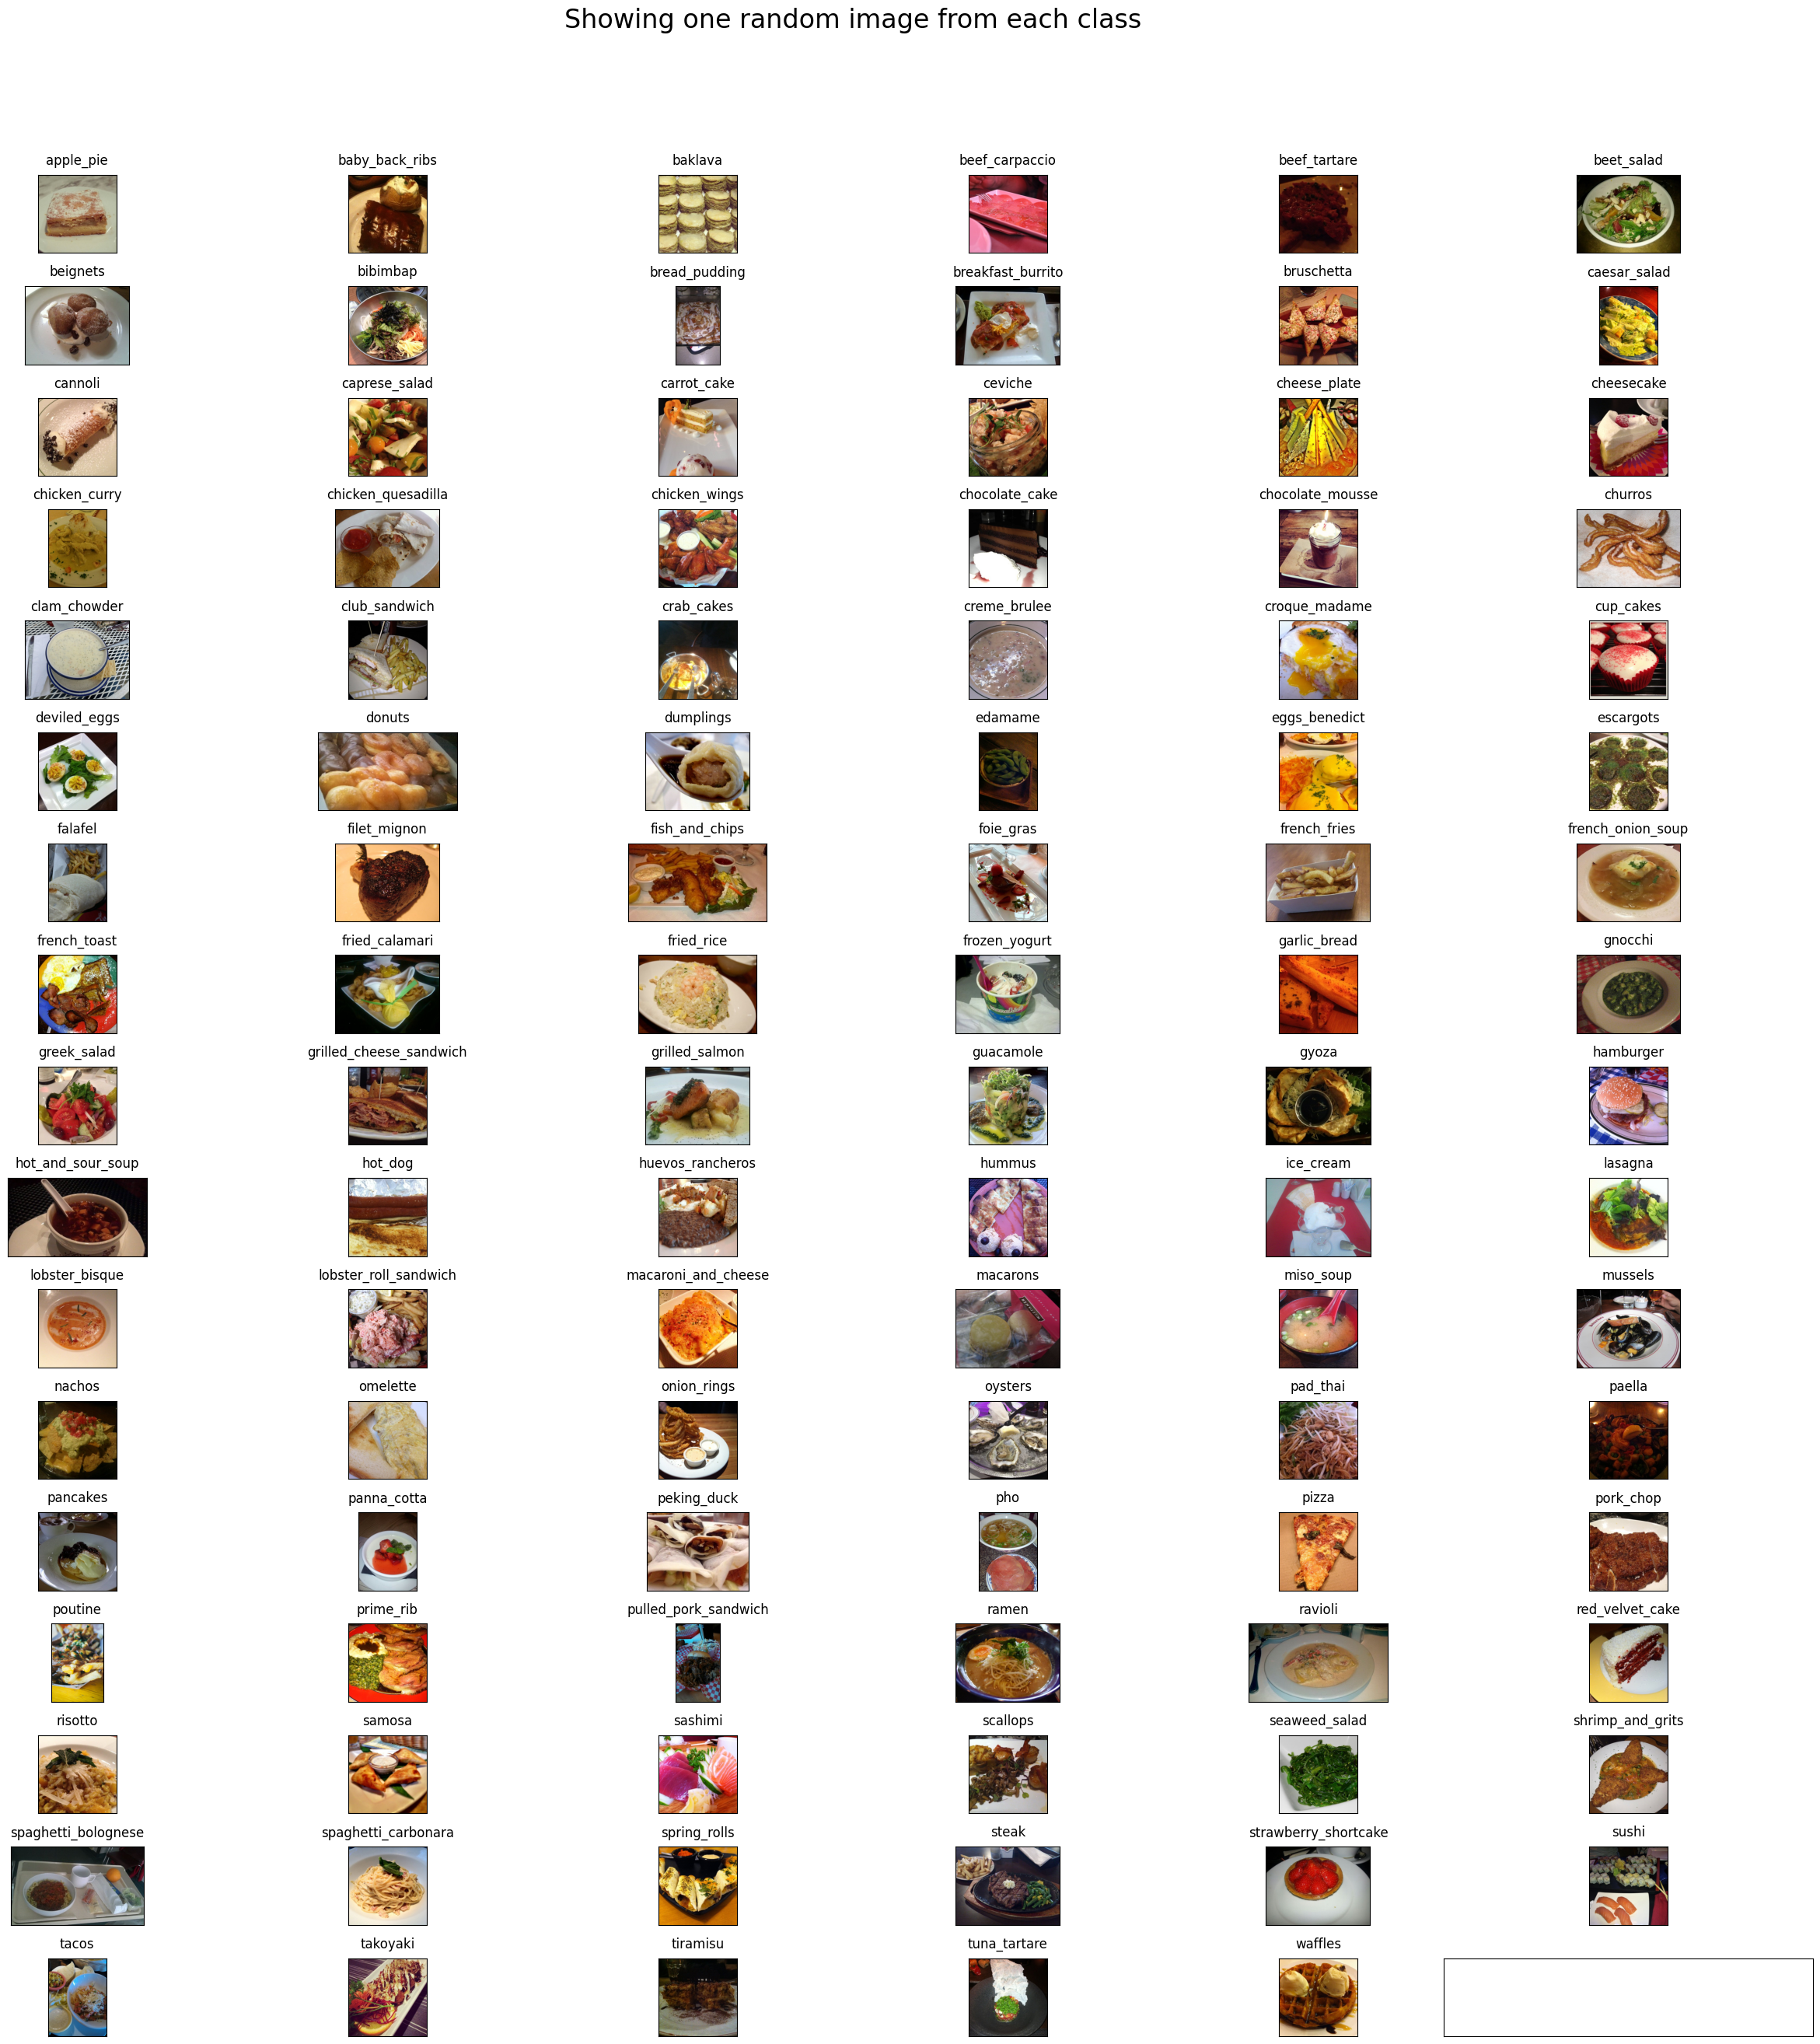

In [ ]:
# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "/content/food-101/images"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id]
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)

plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html


In [ ]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [ ]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
%cd /
print("Creating train data...")
prepare_data('/content/food-101/meta/train.txt', '/content/food-101/images', 'train')

/
Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying 

In [ ]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('/content/food-101/meta/test.txt', '/content/food-101/images', 'test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [ ]:
# Check how many files are in the train folder
print("Total number of samples in train folder")
!find train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
75750


In [ ]:
# Check how many files are in the test folder
print("Total number of samples in test folder")
!find test -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
25250


In [ ]:
os.chdir('/')

In [ ]:
# List of all 101 types of foods(sorted alphabetically)
del foods_sorted[0] # remove .DS_Store from the list

In [ ]:
foods_sorted

['baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster_roll_sandwich

In [ ]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))


In [ ]:
# picking 3 food items and generating separate data folders for the same
food_list = ['apple_pie','pizza','omelette']
src_train = 'train'
dest_train = '/content/working/train_mini'
src_test = 'test'
dest_test = '/content/working/test_mini'

In [ ]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [ ]:
print("Total number of samples in train folder")

!find /content/working/train_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
2250


In [ ]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [ ]:
print("Total number of samples in test folder")
!find /content/working/test_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
750


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

K.clear_session()
n_classes = 3
img_width, img_height = 224, 224
train_data_dir = '/content/working/train_mini'
validation_data_dir = '/content/working/test_mini'
nb_train_samples = 2250 #75750
nb_validation_samples = 750 #25250
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


resnet50 = ResNet50(weights='imagenet', include_top=False)
x = resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(3,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=resnet50.input, outputs=predictions)
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='/content/working/best_model_3class.keras', verbose=1, save_best_only=True)
csv_logger = CSVLogger('/content/working/history_3class.log')

history = model.fit(train_generator, # Changed fit_generator to fit
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('/content/working/model_trained_3class.keras')

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.3927 - loss: 1.2579
Epoch 1: val_loss improved from inf to 1.91198, saving model to /content/working/best_model_3class.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 106s 468ms/step - accuracy: 0.3933 - loss: 1.2567 - val_accuracy: 0.3370 - val_loss: 1.9120
Epoch 2/30
  1/140 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - accuracy: 0.5625 - loss: 0.8462

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 1.91198
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5625 - loss: 0.8462 - val_accuracy: 0.3329 - val_loss: 1.9352
Epoch 3/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.6545 - loss: 0.7858
Epoch 3: val_loss did not improve from 1.91198
140/140 ━━━━━━━━━━━━━━━━━━━━ 40s 283ms/step - accuracy: 0.6547 - loss: 0.7857 - val_accuracy: 0.3302 - val_loss: 2.6388
Epoch 4/30
  1/140 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - accuracy: 0.6875 - loss: 0.8417
Epoch 4: val_loss did not improve from 1.91198
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6875 - loss: 0.8417 - val_accuracy: 0.3342 - val_loss: 2.6389
Epoch 5/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.7496 - loss: 0.6327
Epoch 5: val_loss did not improve from 1.91198
140/140 ━━━━━━━━━━━━━━━━━━━━ 78s 279ms/step - accuracy: 0.7497 - loss: 0.6326 - val_accuracy: 0.3329 - val_loss: 2.4198
Epoch 6/30
  1/140 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - accuracy: 0.6

In [ ]:
class_map_3 = train_generator.class_indices
class_map_3

{'apple_pie': 0, 'omelette': 1, 'pizza': 2}

In [ ]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

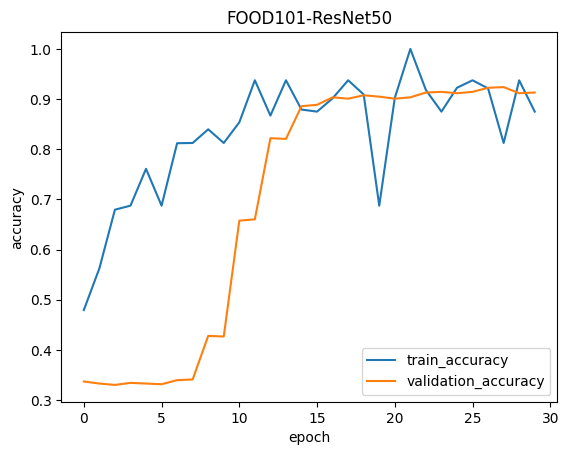

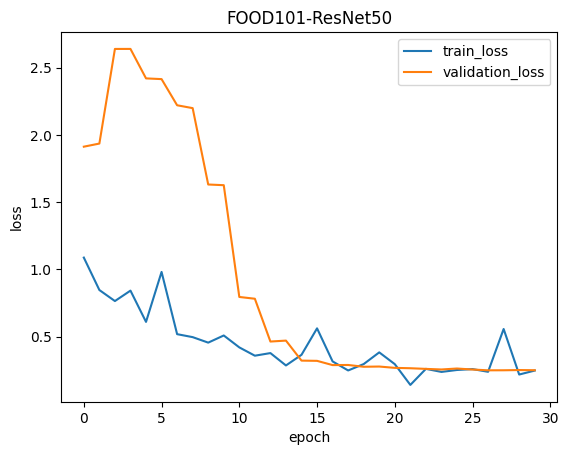

In [ ]:
plot_accuracy(history,'FOOD101-ResNet50')
plot_loss(history,'FOOD101-ResNet50')

In [ ]:
%%time
# Loading the best saved model to make predictions
K.clear_session()
model_best = load_model('/content/working/best_model_3class.keras',compile = False)

CPU times: user 2.31 s, sys: 208 ms, total: 2.52 s
Wall time: 2.61 s


In [ ]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    if show:
        plt.imshow(img[0])
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

In [ ]:
# Downloading images from internet using the URLs
!wget -O samosa.jpg http://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
!wget -O applepie.jpg https://cdn.pixabay.com/photo/2015/12/01/08/13/apple-pie-1071747_640.jpg
!wget -O pizza.jpg https://img.freepik.com/free-photo/top-view-pepperoni-pizza-with-mushroom-sausages-bell-pepper-olive-corn-black-wooden_141793-2158.jpg?w=2000
!wget -O omelette.jpg https://cdn.pixabay.com/photo/2015/05/20/16/11/kitchen-775746_640.jpg

--2025-12-22 15:39:54--  http://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
Resolving veggiefoodrecipes.com (veggiefoodrecipes.com)... 172.67.139.59, 104.21.79.5, 2606:4700:3036::6815:4f05, ...
Connecting to veggiefoodrecipes.com (veggiefoodrecipes.com)|172.67.139.59|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg [following]
--2025-12-22 15:39:55--  https://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
Connecting to veggiefoodrecipes.com (veggiefoodrecipes.com)|172.67.139.59|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-12-22 15:39:58 ERROR 404: Not Found.

--2025-12-22 15:39:58--  https://cdn.pixabay.com/photo/2015/12/01/08/13/apple-pie-1071747_640.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 172.64.147.160, 104.18.40.96, 2606:4700:4400::ac40:93a0, ...
Connec

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


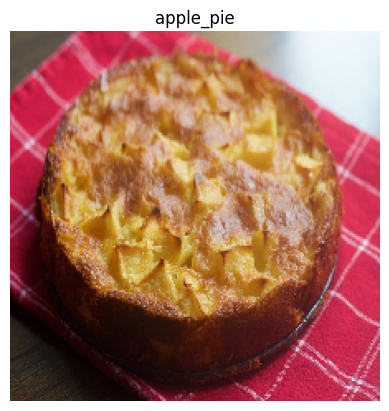

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


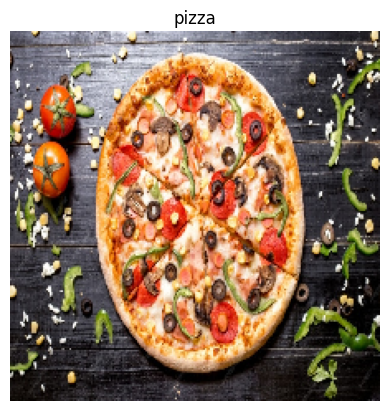

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


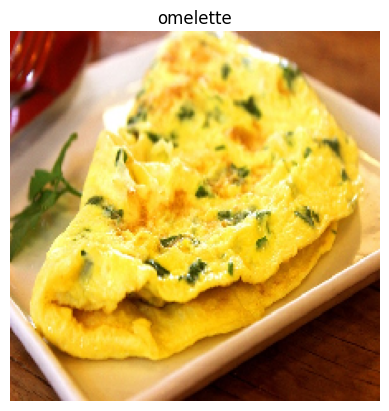

In [ ]:
# Make a list of downloaded images and test the trained model
images = []
images.append('applepie.jpg')
images.append('pizza.jpg')
images.append('omelette.jpg')
predict_class(model_best, images, True)

In [ ]:
# Helper function to select n random food classes
def pick_n_random_classes(n):
  food_list = []
  random_food_indices = random.sample(range(len(foods_sorted)),n) # We are picking n random food classes
  for i in random_food_indices:
    food_list.append(foods_sorted[i])
  food_list.sort()
  return food_list

In [ ]:
# Lets try with more classes than just 3. Also, this time lets randomly pick the food classes
n = 11
food_list = pick_n_random_classes(n)
food_list = ['apple_pie', 'beef_carpaccio', 'bibimbap', 'cup_cakes', 'foie_gras', 'french_fries', 'garlic_bread', 'pizza', 'spring_rolls', 'spaghetti_carbonara', 'strawberry_shortcake']
print("These are the randomly picked food classes we will be training the model on...\n", food_list)

These are the randomly picked food classes we will be training the model on...
 ['apple_pie', 'beef_carpaccio', 'bibimbap', 'cup_cakes', 'foie_gras', 'french_fries', 'garlic_bread', 'pizza', 'spring_rolls', 'spaghetti_carbonara', 'strawberry_shortcake']


In [ ]:
# Create the new data subset of n classes
print("Creating training data folder with new classes...")
dataset_mini(food_list, src_train, dest_train)

Creating training data folder with new classes...
Copying images into apple_pie
Copying images into beef_carpaccio
Copying images into bibimbap
Copying images into cup_cakes
Copying images into foie_gras
Copying images into french_fries
Copying images into garlic_bread
Copying images into pizza
Copying images into spring_rolls
Copying images into spaghetti_carbonara
Copying images into strawberry_shortcake


In [ ]:
print("Total number of samples in train folder")
!find /content/working/train_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
8250


In [ ]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into apple_pie
Copying images into beef_carpaccio
Copying images into bibimbap
Copying images into cup_cakes
Copying images into foie_gras
Copying images into french_fries
Copying images into garlic_bread
Copying images into pizza
Copying images into spring_rolls
Copying images into spaghetti_carbonara
Copying images into strawberry_shortcake


In [ ]:
print("Total number of samples in test folder")
!find /content/working/test_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
2750


In [ ]:
# Let's use a pretrained Resnet model on subset of data with 11 food classes
K.clear_session()

n_classes = n
img_width, img_height = 224, 224
train_data_dir = '/content/working/train_mini'
validation_data_dir = '/content/working/test_mini'
nb_train_samples = 8250 #75750
nb_validation_samples = 2750 #25250
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


resnet50 = ResNet50(weights='imagenet', include_top=False)
x = resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(n,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=resnet50.input, outputs=predictions)
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='/content/working/best_model_11class.keras', verbose=1, save_best_only=True)
csv_logger = CSVLogger('/content/working/history_11class.log')

history_11class = model.fit(train_generator, # Changed fit_generator to fit
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('/content/working/model_trained_11class.keras')

Found 8250 images belonging to 11 classes.
Found 2750 images belonging to 11 classes.
Epoch 1/30
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.2601 - loss: 2.2997
Epoch 1: val_loss improved from inf to 2.49558, saving model to /content/working/best_model_11class.keras
515/515 ━━━━━━━━━━━━━━━━━━━━ 198s 318ms/step - accuracy: 0.2604 - loss: 2.2990 - val_accuracy: 0.1557 - val_loss: 2.4956
Epoch 2/30
  1/515 ━━━━━━━━━━━━━━━━━━━━ 1:16 148ms/step - accuracy: 0.8125 - loss: 1.0168
Epoch 2: val_loss did not improve from 2.49558
515/515 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8125 - loss: 1.0168 - val_accuracy: 0.1568 - val_loss: 2.4967
Epoch 3/30
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.6389 - loss: 1.2316
Epoch 3: val_loss improved from 2.49558 to 0.76540, saving model to /content/working/best_model_11class.keras
515/515 ━━━━━━━━━━━━━━━━━━━━ 143s 278ms/step - accuracy: 0.6390 - loss: 1.2314 - val_accuracy: 0.7913 - val_loss: 0.7654
Epoch 4/30
  1/515 ━━━━━━

In [ ]:
class_map_11 = train_generator.class_indices
class_map_11

{'apple_pie': 0,
 'beef_carpaccio': 1,
 'bibimbap': 2,
 'cup_cakes': 3,
 'foie_gras': 4,
 'french_fries': 5,
 'garlic_bread': 6,
 'pizza': 7,
 'spaghetti_carbonara': 8,
 'spring_rolls': 9,
 'strawberry_shortcake': 10}

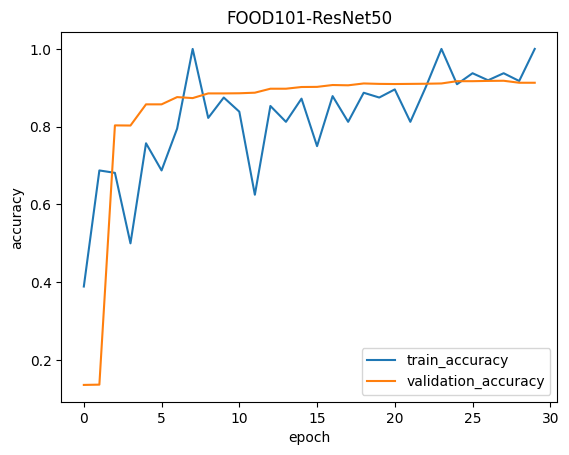

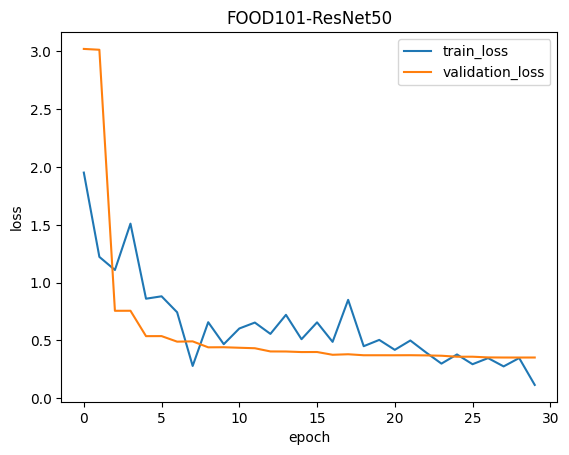

In [ ]:
plot_accuracy(history_11class,'FOOD101-ResNet50')
plot_loss(history_11class,'FOOD101-ResNet50')

In [ ]:
%%time
# Loading the best saved model to make predictions
K.clear_session()
model_best = load_model('/content/working/best_model_11class.keras',compile = False)

CPU times: user 1.97 s, sys: 142 ms, total: 2.11 s
Wall time: 2.1 s


In [ ]:
# Downloading images from internet using the URLs
!wget -O cupcakes.jpg https://www.publicdomainpictures.net/pictures/110000/nahled/halloween-witch-cupcakes.jpg
!wget -O springrolls.jpg https://www.sidechef.com/recipe/b75f5913-ca28-41a7-b985-30ab40045d7a.jpg?d=1408x1120
# !wget -O pizza.jpg http://104.130.3.186/assets/itemimages/400/400/3/default_9b4106b8f65359684b3836096b4524c8_pizza%20dreamstimesmall_94940296.jpg
!wget -O garlicbread.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/5/59/Garlicbread.jpg/500px-Garlicbread.jpg

# If you have an image in your local computer and want to try it, uncomment the below code to upload the image files


# from google.colab import files
# image = files.upload()

--2025-12-22 06:36:26--  https://www.publicdomainpictures.net/pictures/110000/nahled/halloween-witch-cupcakes.jpg
Resolving www.publicdomainpictures.net (www.publicdomainpictures.net)... 172.66.140.55, 172.66.134.60, 2606:4700:10::ac42:8c37, ...
Connecting to www.publicdomainpictures.net (www.publicdomainpictures.net)|172.66.140.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48618 (47K) [image/jpeg]
Saving to: ‘cupcakes.jpg’

cupcakes.jpg        100%[===================>]  47.48K  --.-KB/s    in 0s      

2025-12-22 06:36:26 (142 MB/s) - ‘cupcakes.jpg’ saved [48618/48618]

--2025-12-22 06:36:26--  https://www.sidechef.com/recipe/b75f5913-ca28-41a7-b985-30ab40045d7a.jpg?d=1408x1120
Resolving www.sidechef.com (www.sidechef.com)... 18.164.174.49, 18.164.174.46, 18.164.174.91, ...
Connecting to www.sidechef.com (www.sidechef.com)|18.164.174.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 163652 (160K) [image/jpeg]
Saving to: ‘sprin

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


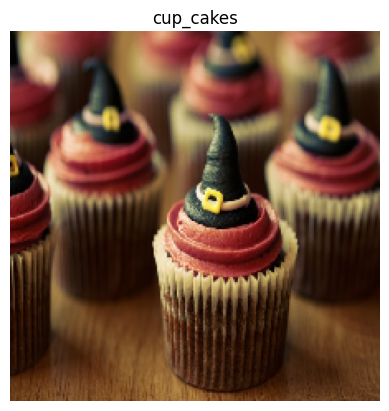

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


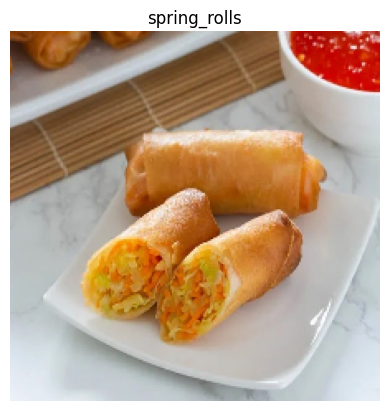

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


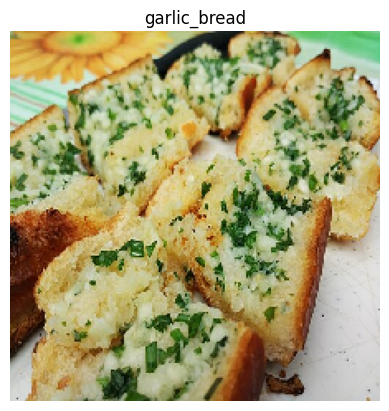

In [ ]:
# Make a list of downloaded images and test the trained model
images = []
images.append('cupcakes.jpg')
# images.append('pizza.jpg')
images.append('springrolls.jpg')
images.append('garlicbread.jpg')
predict_class(model_best, images, True)

In [ ]:
os.chdir("/content/working")